In [1]:
#%%
#get eigenworms using PCA 
import copy
import yaml
import numpy as np
import cv2
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import pickle
import copy
import numpy as np
import pandas as pd

import sys
import os 
import copy

from scipy.interpolate import interp1d

from functools import partial

'''change the directory below'''
import sys 
sys.path.append('/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/')

from get_data.read_neuro_beh_data_high_fps import get_exp_features as get_exp_features_fps
from beh_classification.behavior_features import get_behavior_features
from beh_classification.get_behavior_classifications import get_behavior_classification

# from beh_analysis.behavior_features import convert_angles_to_coordinates, get_beh_classification
# from get_data.read_neuro_beh_data import get_processed_beh_features
from get_data.read_neuro_beh_data import get_exp_features 
# from get_data.flavell_raw_nir_extraction.convert_nir_to_confocal import convert_nir_to_confocal
from get_data.flavell_raw_nir_extraction.convert_nir_to_confocal import convert_nir_to_confocal,convert_confocal_to_nir,  evenly_sample_nir
from beh_classification.img_mask_specific_features import get_is_looping_from_mask_dir_confocal
from beh_classification.process_midlines.midline_utils import compute_spline_lengths, get_midlines_from_worm_tracer_csv, convert_coordinates_to_angles, resample_midline, convert_angles_to_coordinates
from beh_classification.process_midlines.midline_utils import save_as_csv, load_from_csv
from beh_classification.process_midlines.eigenworm_utils import get_PCA_components_from_midlines, get_contributions_and_reconstruct_body_angles, get_cropped_midlines_eigenworms_and_body_angles

from save_img_utils.save_img_utils import get_text_nir_midlines, save_masked_imgs_and_annotations
from save_img_utils.save_resampled_imgs import save_confocal_midlines_and_masks, evenly_sample_nir_and_save, evenly_sample_feature


In [2]:
def make_new_folder(output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    return output_dir

In [3]:
save_csvs = True
save_figs = True
save_imgs = True
save_mask_img = True

'''
change these directories
'''
base_save_dir = "/Users/friederikebuck/Desktop/MBL/project/outputs/"
base_code_dir = "/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/"
# base_data_dir = "/Volumes/FB1/flavell_midlines/flavell_data_processed_midlines/noheat/"
base_data_dir = "/Users/friederikebuck/Downloads/noheat/"
exp_params_yml ="/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/exp_date_params.yaml"


#2023-01-09-28"
#"2022-07-26-01"
# exp_date = "2022-07-20-01"
exp_date = "2022-06-14-13"

In [4]:
# json_dir = "/Users/friederikebuck/Desktop/MBL/project/data/Neuropal_no_heat/"
# h5_dir = "/Volumes/Extreme SSD/data/data_processed_high_fps/h5/"
# beh_data_fps, neural_data, neuroID_to_key = get_exp_features_fps(exp_date, 
#                                                             json_dir = json_dir, 
#                                                             h5_dir = h5_dir, 
#                                                             h5_suffix = "_output_data_dicts.h5" 
#                                                             )

# nir_to_confocal = beh_data_fps["nir_to_confocal"].astype('int32')[1:]


# csv_name = os.path.join(csv_save_dir, f"nir_to_confocal.csv")
# np.savetxt(csv_name,  nir_to_confocal, delimiter=",", fmt='%f')

# ''''
# intuition for nir_to_confocal: 

# nir_to_confocal is a (n_nir_timestamps, ) with values 0-1600 indicating which timesteps of nir are avergage together to get confocal timesetep
# values of 0 should be ignored (so np.argwhere(nir_to_confocal==i) are the timsetepsh that sould be coutns towards confocal timetep i-1)

# '''

# speed_stage_confocal = beh_data_fps["speed_stage"]
# speed_stage_nir = beh_data_fps["nir_speed_stage"][1:]

# print(nir_to_confocal)
# fig, ax = plt.subplots()
# ax.plot(nir_to_confocal)
# ax.set_title("nir to confocal")

# fig, ax = plt.subplots()
# plt.plot(speed_stage_confocal)
# plt.plot(convert_nir_to_confocal(nir_to_confocal, speed_stage_nir)[1:])
# n_frames_confocal = max(np.unique(nir_to_confocal))
# print("n_frames_confocal", n_frames_confocal)

In [5]:
'''load in high nir data sampled at higher fps 
I was using this more before we got the raw imgs; now that we have the raw images the only really relative feature here is 
nir_to_confocal = beh_data_fps["nir_to_confocal"]
which maps the frames from the nir fps to the frames in the confocal fps

need to ignore  when beh_data["nir_to_confocal"] == 0
'''

with open(exp_params_yml, 'r') as file:
    params = yaml.safe_load(file)
    if exp_date in params:
        exp_params = params[exp_date]
    else: 
        exp_params = {
            "midline_flipped": False, 
            "mask_start_end_is": []
        }

    
# get yaml params 
frames_to_mask = [list(range(item['start'], item['end'] + 1)) for item in exp_params['mask_start_end_is']]
if len(frames_to_mask)>0:
    frames_to_mask = np.concatenate([np.array(f) for f in frames_to_mask])
else: 
    frames_to_mask = np.array([])
is_midline_flipped = exp_params["midline_flipped"]

csv_save_dir = make_new_folder(os.path.join(base_save_dir,f"{exp_date}/csvs/"))
fig_save_dir = make_new_folder(os.path.join(base_save_dir, f"{exp_date}/figs/"))
img_save_dir = make_new_folder(os.path.join(base_save_dir, f"{exp_date}/imgs/"))

raw_nir_midlines_dir = os.path.join(base_data_dir, f"{exp_date}/results/") 
mask_img_dir = os.path.join(base_data_dir, f"{exp_date}/masked_imgs/")
bin_img_dir = os.path.join(base_data_dir, f"{exp_date}/bin_imgs/")


csv_name = os.path.join(csv_save_dir, f"nir_to_confocal.csv")
nir_to_confocal = np.loadtxt(csv_name, delimiter=",")
n_frames_nir = nir_to_confocal.shape[0]
n_frames_confocal = max(np.unique(nir_to_confocal))





In [6]:
'''get self-intersection frames to be incorporated in to beh classificaion (for turns )'''

is_looping_bin_img_confocal, a_to_ps, areas = get_is_looping_from_mask_dir_confocal(n_frames_nir, 
                                        n_frames_confocal
                                        ,nir_to_confocal, bin_img_dir, area_to_perimeter_ratio_thres = 1, area_to_perimeter = 6)



In [7]:
if save_csvs:
    csv_name = os.path.join(csv_save_dir, "is_looping_confocal.csv")
    print("csv_save_dir", csv_save_dir)
    np.savetxt(csv_name,  is_looping_bin_img_confocal, delimiter=",", fmt='%f')

csv_save_dir /Users/friederikebuck/Desktop/MBL/project/outputs/2022-06-14-13/csvs/


768.0
n_looping 0
n_looping 0
n_looping 0
n_looping 0
n_looping 0
n_looping 0
n_looping 0
n_looping 0
n_looping 1
n_looping 1
n_looping 1
n_looping 12
n_looping 11
n_looping 12
n_looping 3
n_looping 2
n_looping 29
n_looping 15
n_looping 113
n_looping 328
n_looping 577
n_looping 748
n_looping 799


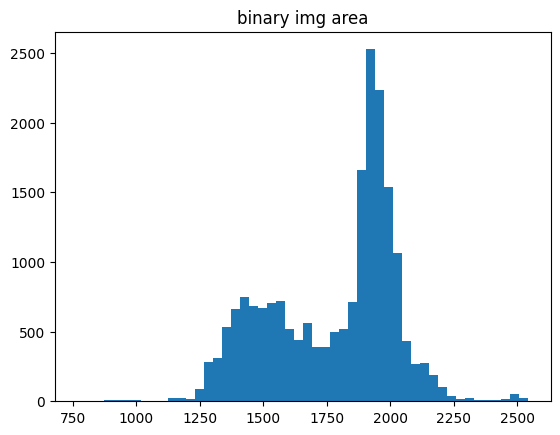

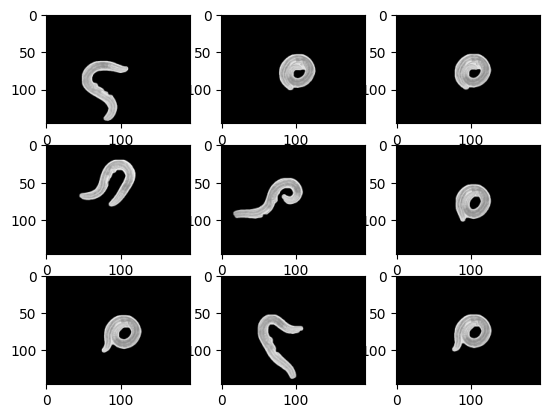

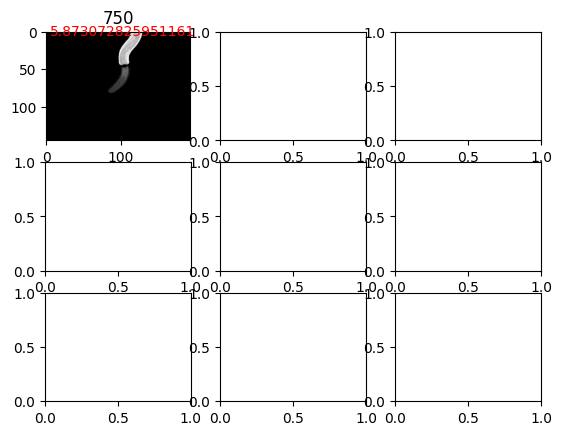

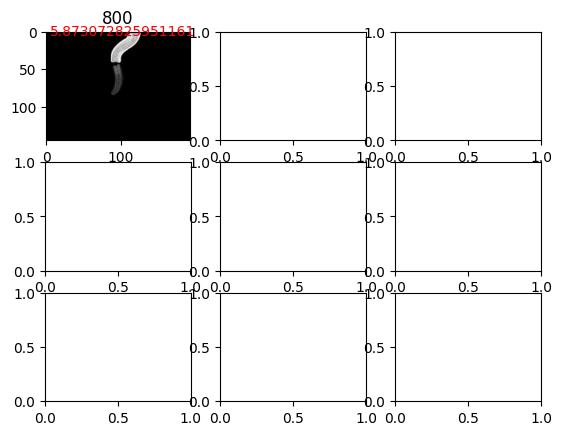

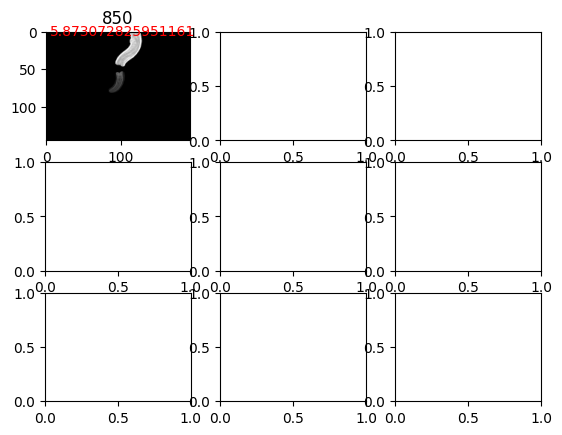

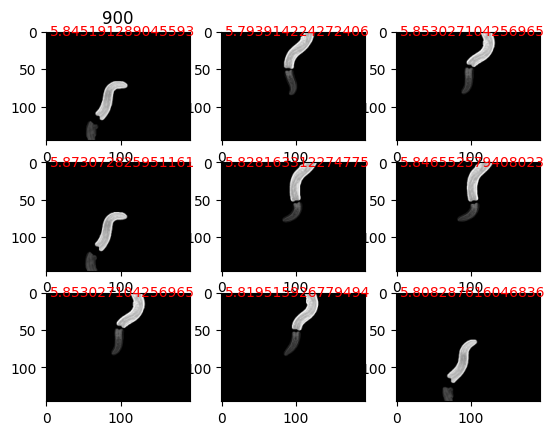

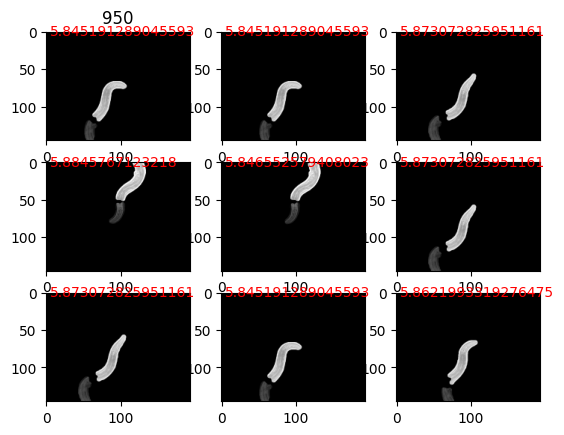

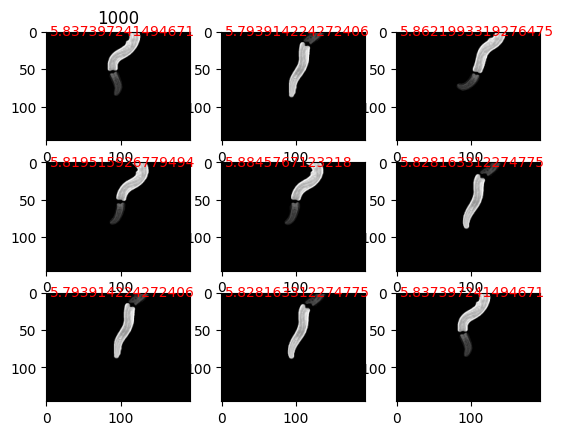

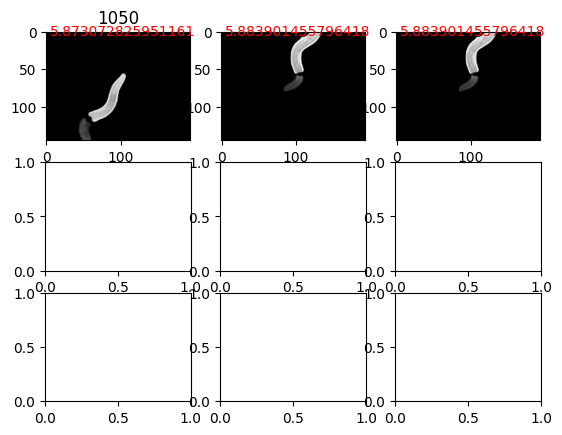

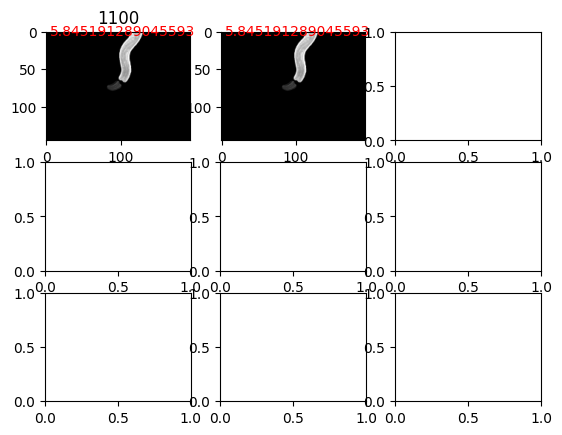

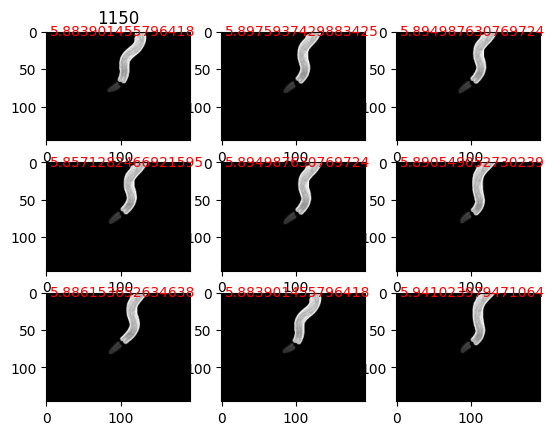

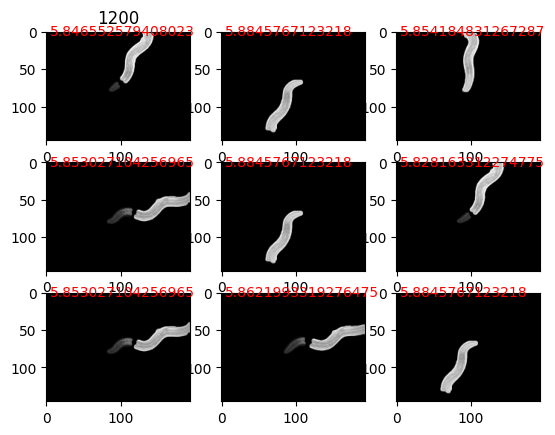

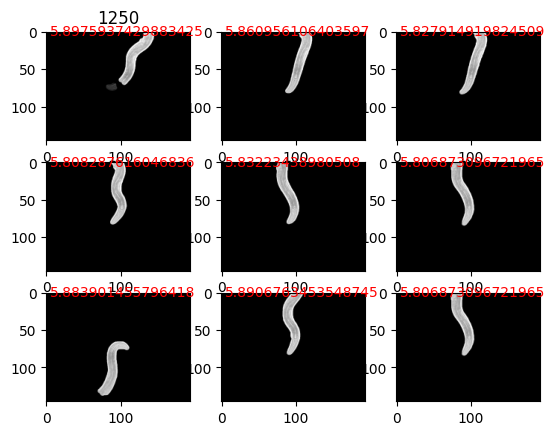

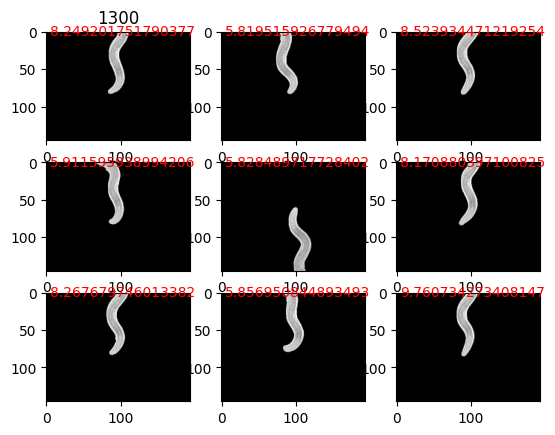

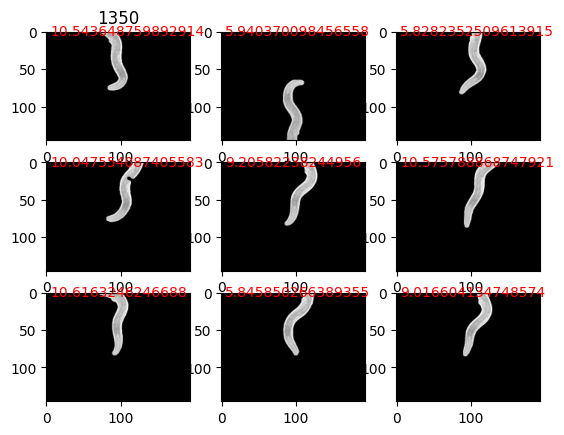

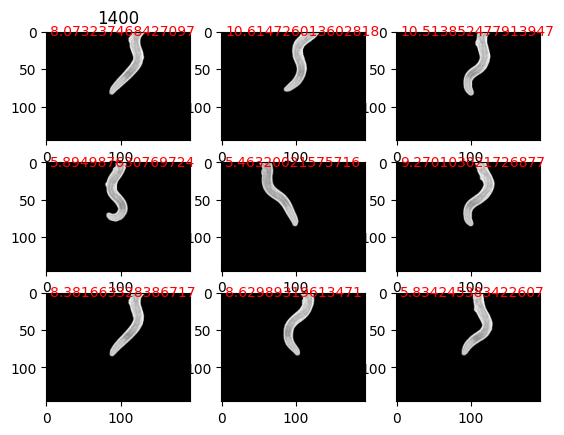

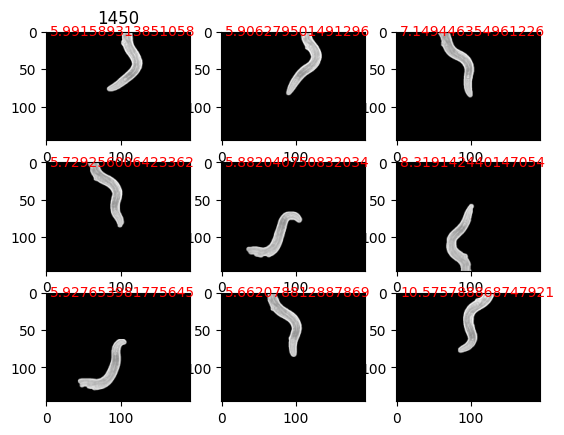

In [8]:
'''
look at areas  - probs a cut off for loopning midliens that is ok

'''

'''plot area to peirmeter ration to have good idea of good param looping frames'''
plt.hist(areas, bins = 50)
plt.title("binary img area")
'''print example looping frames'''
looping_frames = np.argwhere(is_looping_bin_img_confocal).flatten()
n_looping = looping_frames.shape[0]
frames = np.random.randint(0, n_looping, 9).tolist()

fig, ax = plt.subplots(3,3)
for i, frame in enumerate(frames):
    row, col = divmod(i, 3)
    img = cv2.imread(os.path.join(mask_img_dir, str(looping_frames[frame]+1).zfill(5)+".png"))
    ax[row, col].imshow(img)
    
error = 20
# for a_to_p_thres in np.arange(5.9, 6.4, 0.1):

print(min(areas))
for a_to_p_thres in np.arange(350,1500, 50):
    looping_frames = np.argwhere(np.abs((areas-a_to_p_thres))<error).flatten()
    n_looping = looping_frames.shape[0]
    print("n_looping", n_looping)
    if n_looping == 0: 
        continue
    n_pics = min(n_looping, 9)
    frames = np.random.randint(0, n_looping, n_pics).tolist()
    fig, ax = plt.subplots(3,3)
    ax[0,0].set_title(str(a_to_p_thres))
    for i, frame in enumerate(frames):
        row, col = divmod(i, 3)
        img = cv2.imread(os.path.join(mask_img_dir, str(looping_frames[frame]+1).zfill(5)+".png"))
        ax[row, col].imshow(img)
        ax[row,col].text(5,5,str(a_to_ps[frame]), color = "red")
    # if save_figs:
    #     plt.savefig(os.path.join(fig_save_dir, f"a_to_p{a_to_p_thres}_examples.jpeg"))

n_looping 1129
n_looping 509
n_looping 100
n_looping 19
n_looping 3
n_looping 0
n_looping 0
n_looping 3
n_looping 2
n_looping 5
n_looping 8
n_looping 7
n_looping 22
n_looping 32
n_looping 37
n_looping 53


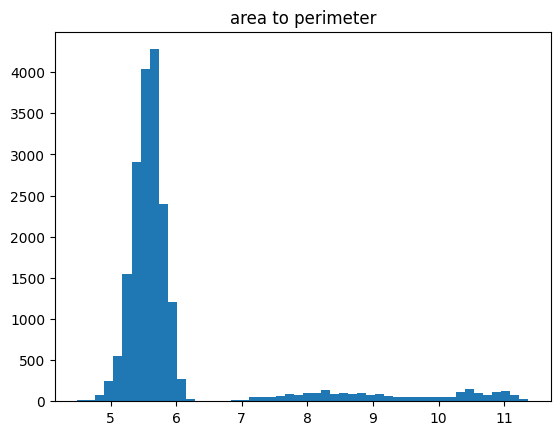

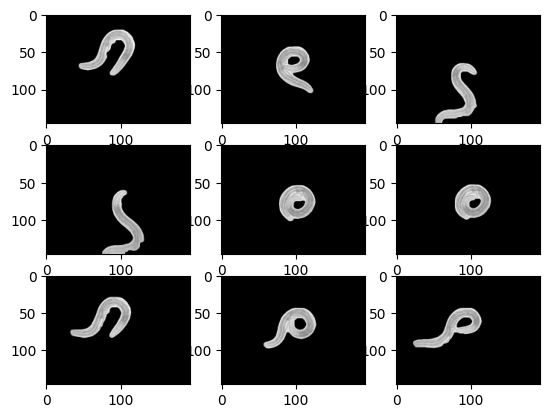

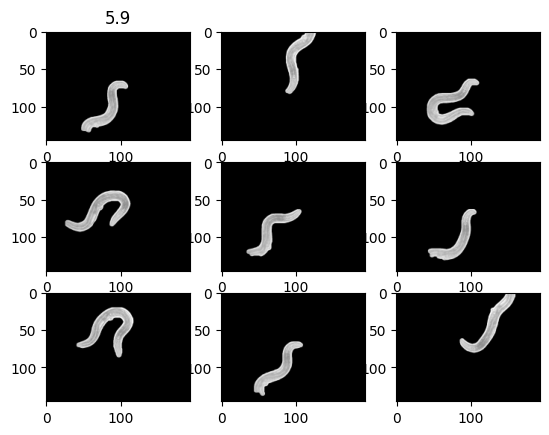

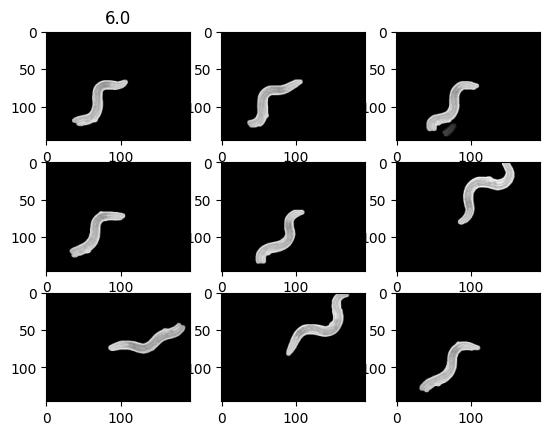

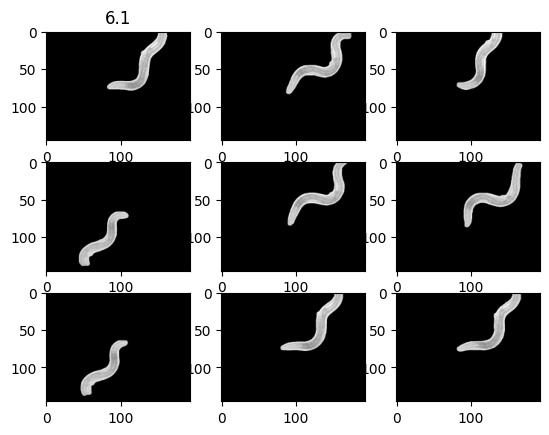

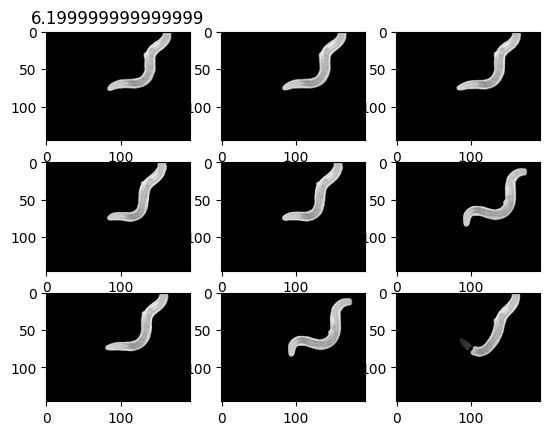

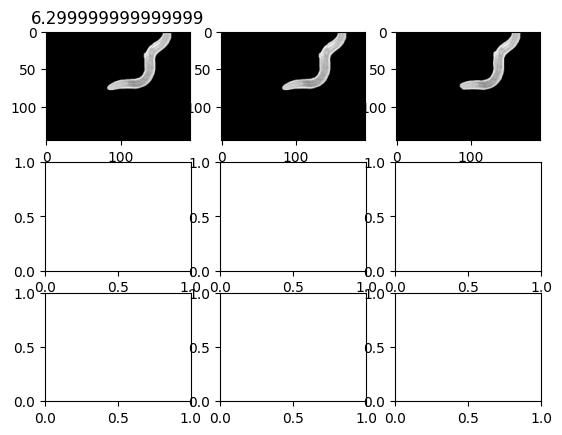

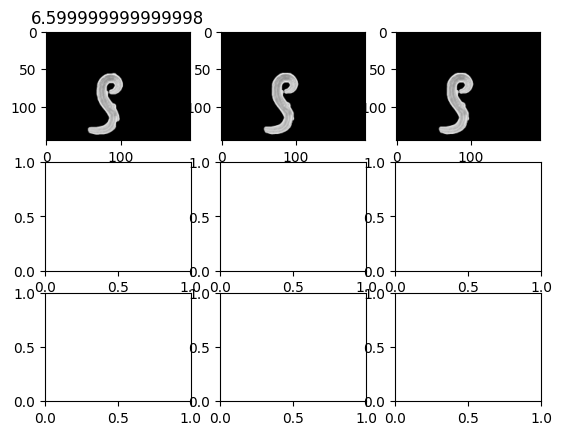

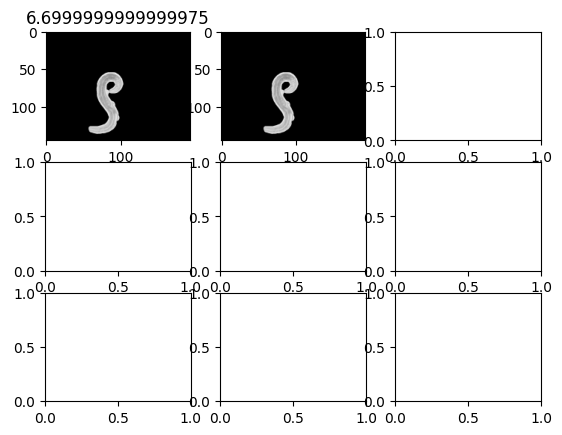

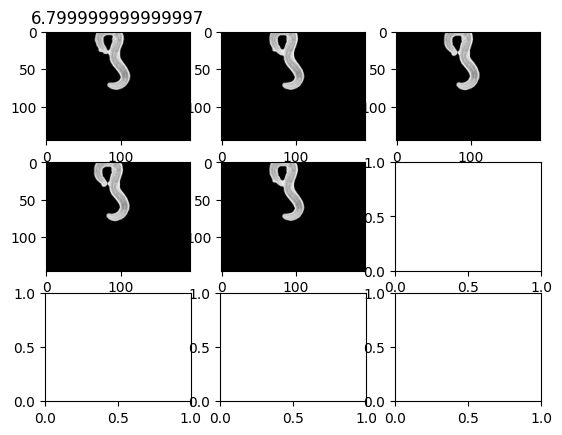

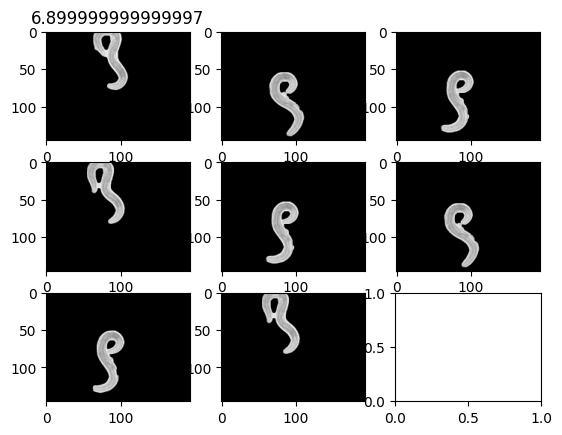

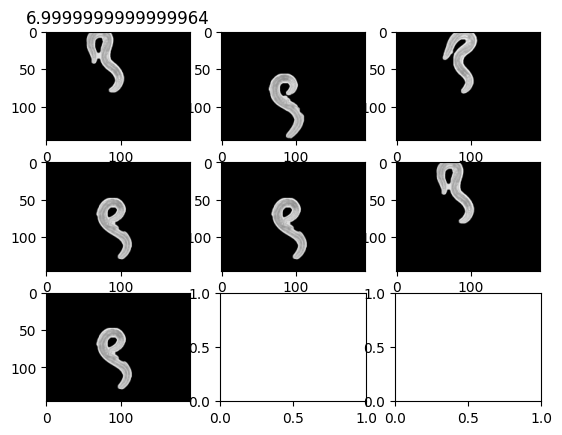

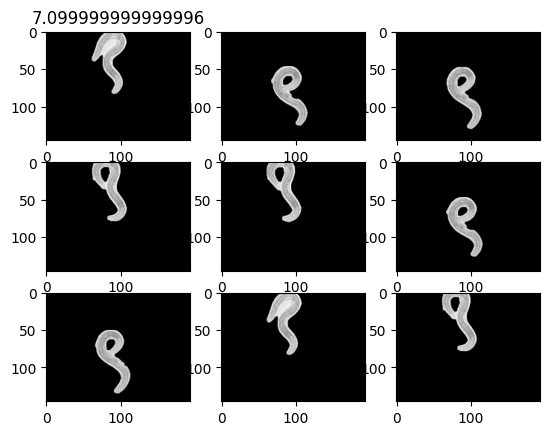

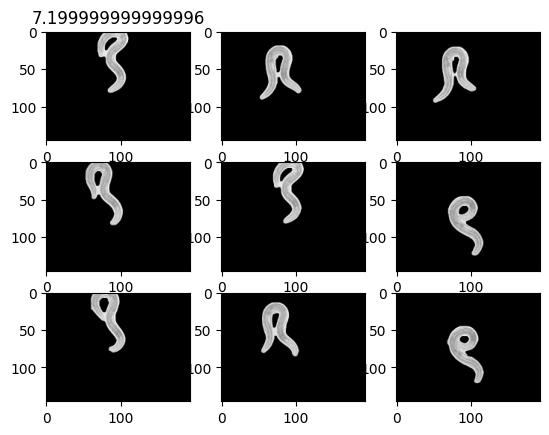

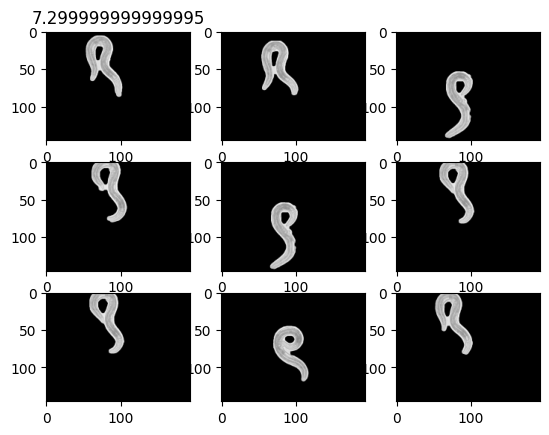

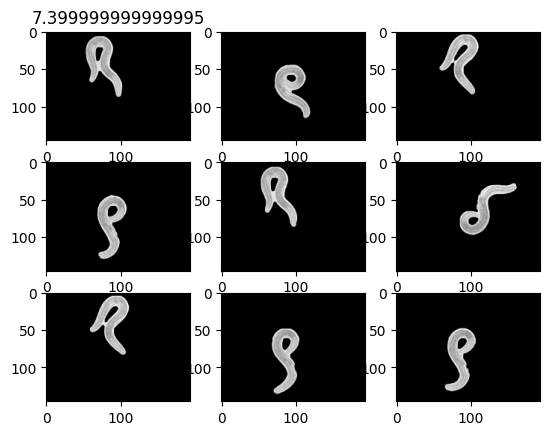

In [9]:
'''plot area to peirmeter ration to have good idea of good param looping frames'''
plt.hist(a_to_ps, bins = 50)
plt.title("area to perimeter")
'''print example looping frames'''
looping_frames = np.argwhere(is_looping_bin_img_confocal).flatten()
n_looping = looping_frames.shape[0]
frames = np.random.randint(0, n_looping, 9).tolist()

fig, ax = plt.subplots(3,3)
for i, frame in enumerate(frames):
    row, col = divmod(i, 3)
    img = cv2.imread(os.path.join(mask_img_dir, str(looping_frames[frame]+1).zfill(5)+".png"))
    ax[row, col].imshow(img)
    
error = 0.05
# for a_to_p_thres in np.arange(5.9, 6.4, 0.1):


for a_to_p_thres in np.arange(5.9, 7.5, 0.1):
    looping_frames = np.argwhere(np.abs((a_to_ps-a_to_p_thres))<error).flatten()
    n_looping = looping_frames.shape[0]
    print("n_looping", n_looping)
    if n_looping == 0: 
        continue
    n_pics = min(n_looping, 9)
    frames = np.random.randint(0, n_looping, n_pics).tolist()
    fig, ax = plt.subplots(3,3)
    ax[0,0].set_title(str(a_to_p_thres))
    for i, frame in enumerate(frames):
        row, col = divmod(i, 3)
        img = cv2.imread(os.path.join(mask_img_dir, str(looping_frames[frame]+1).zfill(5)+".png"))
        ax[row, col].imshow(img)
    if save_figs:
        plt.savefig(os.path.join(fig_save_dir, f"a_to_p{a_to_p_thres}_examples.jpeg"))
    

/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/beh_classification/behavior_features.py:11: RuntimeWarning: Mean of empty slice
  body_angles = body_angles-np.nanmean(body_angles, axis = 1)[:, None]
/Users/friederikebuck/Desktop/MBL/project/WholeBrainImagingAnalysis/collab/beh_classification/behavior_features.py:15: RuntimeWarning: Mean of empty slice
  centroids = np.nanmean(midlines, axis = 1)


Text(0.5, 1.0, 'velocity')

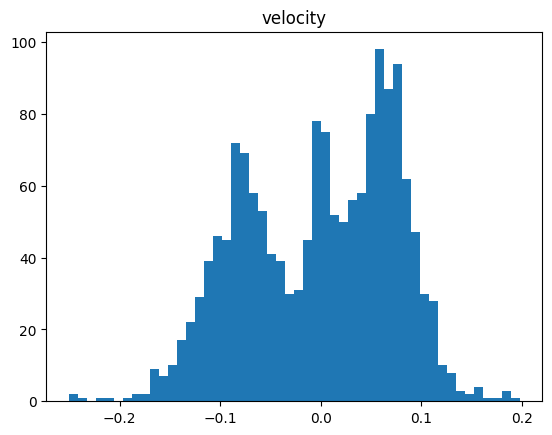

In [10]:
'''
load in data sampled at confocal fps
'''

json_dir = "/Users/friederikebuck/Desktop/MBL/project/data/Neuropal_no_heat/"
h5_dir ="/Users/friederikebuck/Desktop/MBL/project/data/processed_h5/"
dt, T, beh_data_confocal, _, _ = get_exp_features(exp_date, 
                                                            json_dir = json_dir, 
                                                            h5_dir = h5_dir)
behavior_features = get_behavior_features(beh_data_confocal)
beh_data_confocal.update(behavior_features)

behavior_classification_confocal = get_behavior_classification(beh_data_confocal, n_looping_pts_thres = 0.3, looping = is_looping_bin_img_confocal)
z_confocal = behavior_classification_confocal["is_fwd"]+ 2*behavior_classification_confocal["is_rev"]+ 4*behavior_classification_confocal["is_pause"]+3*behavior_classification_confocal["is_turn"]-1     
z_confocal = z_confocal.astype('int32')
z_nir = convert_confocal_to_nir(nir_to_confocal, z_confocal, indices_to_skip = set([])).astype('int32')
z_nir = z_nir.astype('int32')
z_nir[nir_to_confocal==0] = 4
beh = [
    "fwd", 
    "rev",
    "turn", 
    "pause", 
    "nan"
]
beh_strs = [beh[i] for i in z_nir]
beh_strs_confocal = [beh[i] for i in z_confocal]

velocity_nir =  convert_confocal_to_nir(nir_to_confocal, 
                                        beh_data_confocal["velocity"], 
                                        indices_to_skip = set([])).astype('int32')

fig, ax = plt.subplots()
ax.hist(beh_data_confocal["velocity"], bins = 50)
ax.set_title("velocity")


nlengths>length 20048
nlengths>length 20048
nlengths>length 20048
nlengths>length 20048
nlengths>length 20032
nlengths>length 20000
nlengths>length 18934
nlengths>length 16006
nlengths>length 12754
nlengths>length 5986


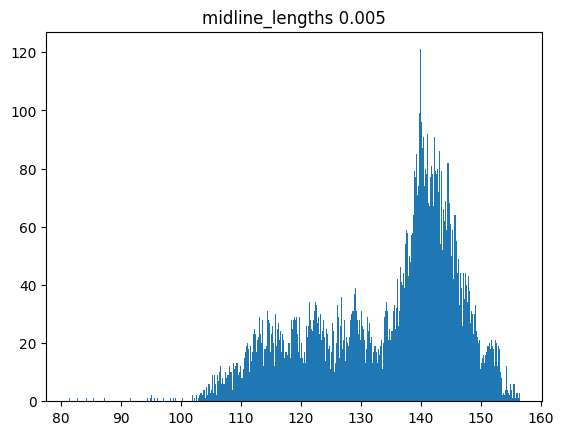

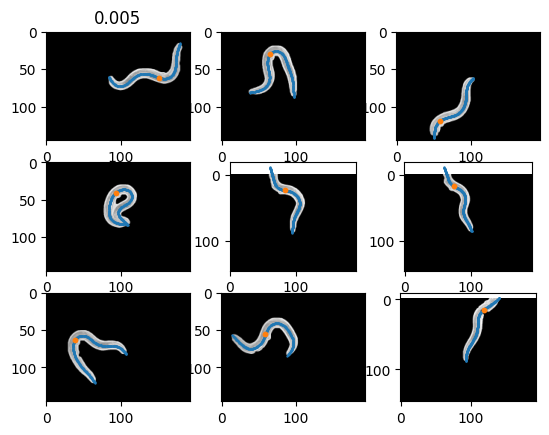

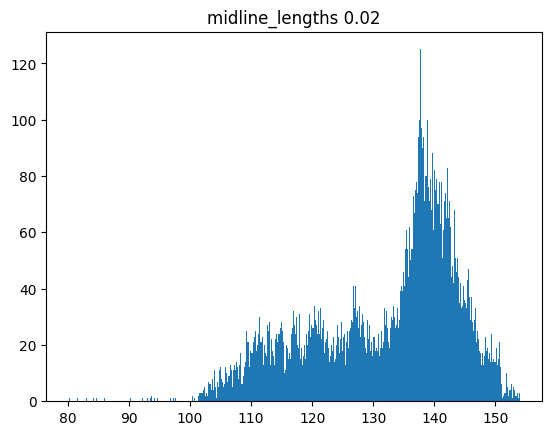

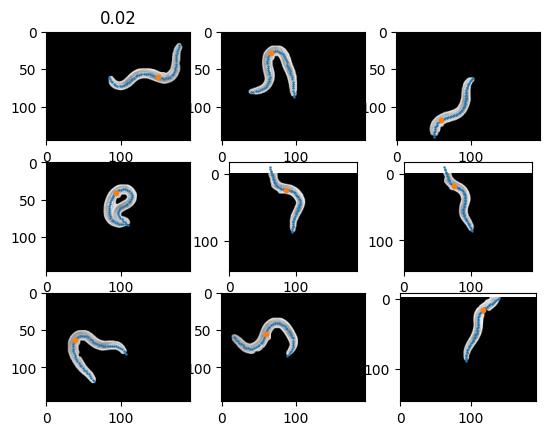

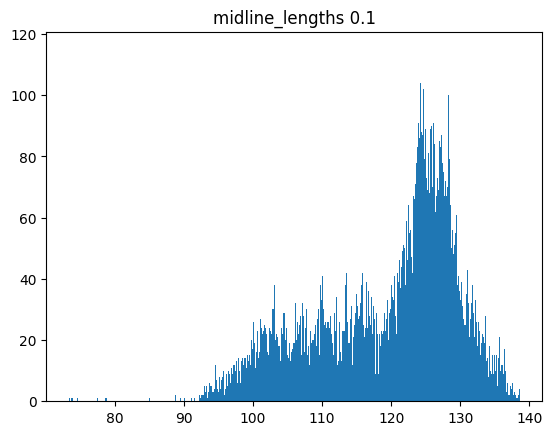

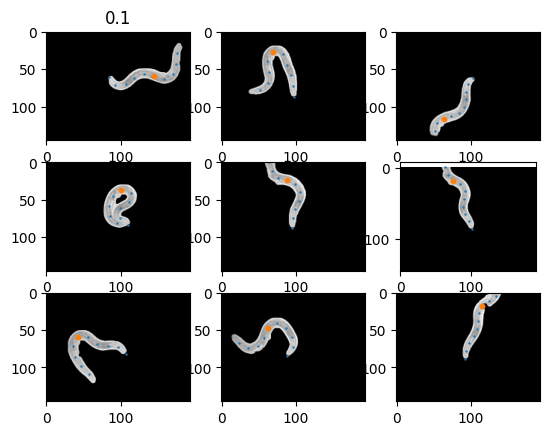

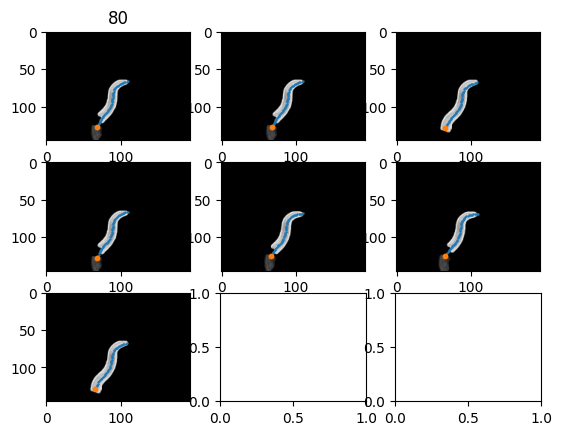

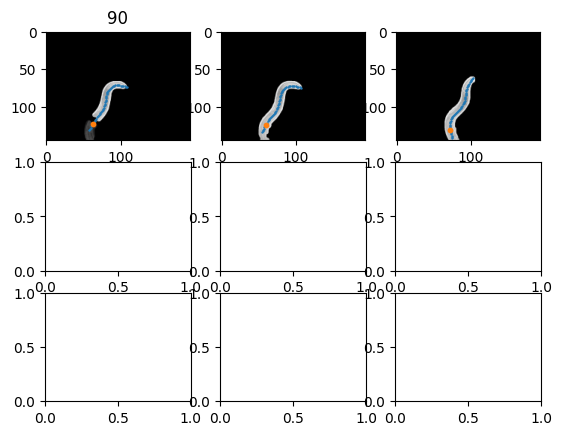

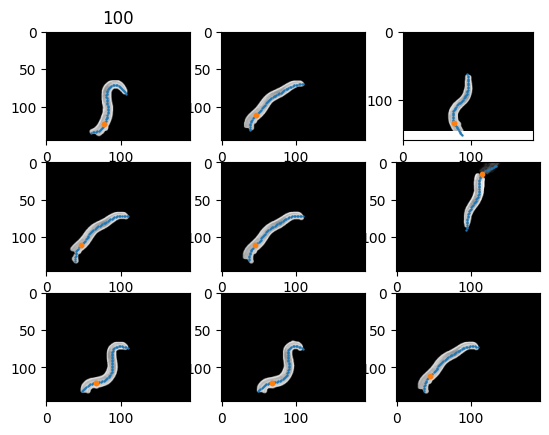

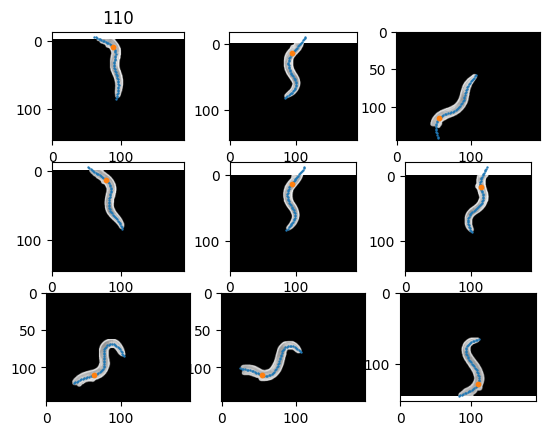

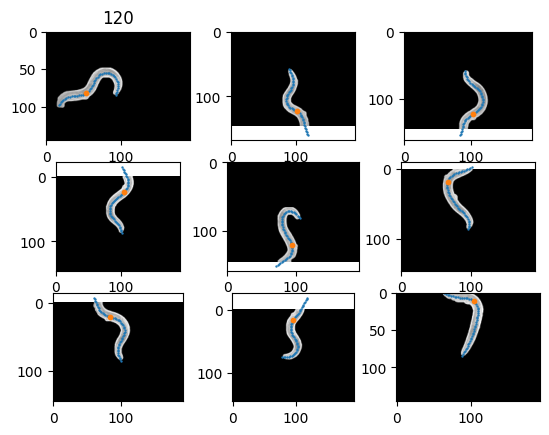

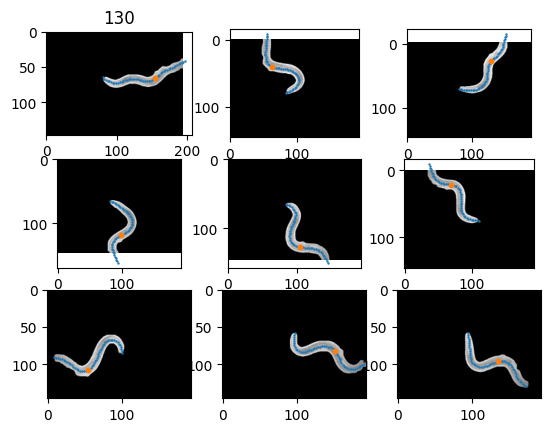

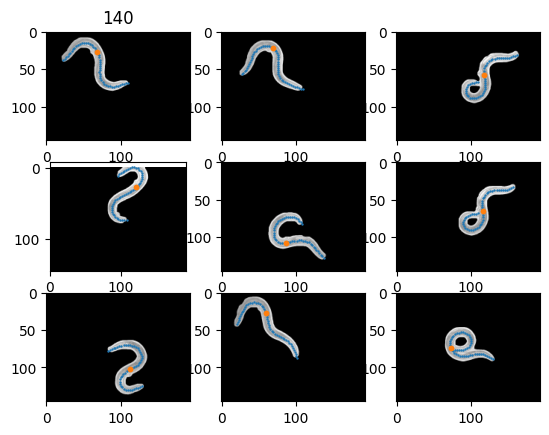

In [11]:


'''
from looking at mask imgs, it looks like midlines can be cut off; this is an issue for downstream analysis if different midlines are very different lengths...

I am assuming that the tail doesn't contribute much of the variance in behavior (an assumption that can be tested); thus one option is to only do analysis on 
the upper fraction of the midline. 

But, first, I have to get a good measure of midline length. I am fitting a spline and testing differnt ds's over which to integrate ....
based on the plots below, ds<0.05 seems fine 
'''

midlines = get_midlines_from_worm_tracer_csv(raw_nir_midlines_dir, is_midline_flipped = is_midline_flipped)
n_frames = midlines.shape[0]
frames = np.random.randint(0, n_frames, 9).tolist()
n_frames = len(frames)
for ds in [0.005, 0.02, 0.1]:#np.arange(0.001, 0.1, 0.01):
    fig, ax = plt.subplots()
    midline_lengths, splines, indices  = compute_spline_lengths(midlines, ds=ds, smoothing = 0 )
    ax.hist(midline_lengths, bins = 1000)
    ax.set_title("midline_lengths " + str(ds))
    if save_figs:
        fig.savefig(os.path.join(fig_save_dir, f"{ds}_length_hist.jpeg"))
    
    
    fig, ax = plt.subplots(3,3)
    ax[0,0].set_title(str(ds))
    for i, frame in enumerate(frames):
        row, col = divmod(i, 3)
        img = cv2.imread(os.path.join(mask_img_dir, str(frame+1).zfill(5)+".png"))
        ax[row, col].imshow(img)
        ax[row, col].scatter(*splines[frame].T, s = 0.5)
        ax[row, col].scatter(*splines[frame, indices[frame], :].T, s = 10)
    if save_figs:
        fig.savefig(os.path.join(fig_save_dir, f"{ds}_ex_midlines.jpeg"))
ds = 0.02
midline_lengths, splines, indices  = compute_spline_lengths(midlines, ds=ds, smoothing = 0 )
error = 2 
for length in np.arange(50, 145, 10):
    len_frames = np.argwhere(np.abs((midline_lengths-length))<error).flatten()
    n_len_frames = len_frames.shape[0]
    print("nlengths>length", np.argwhere(midline_lengths>length).shape[0])
    if n_len_frames == 0: 
        continue
    n_pics = min(n_len_frames, 9)
    frames = np.random.randint(0, n_len_frames, n_pics).tolist()
    fig, ax = plt.subplots(3,3)
    ax[0,0].set_title(str(length))
    for i, frame in enumerate(frames):
        row, col = divmod(i, 3)
        img = cv2.imread(os.path.join(mask_img_dir, str(len_frames[frame]+1).zfill(5)+".png"))
        ax[row, col].imshow(img)
        ax[row, col].scatter(*splines[len_frames[frame]].T, s = 0.5)
        ax[row, col].scatter(*splines[len_frames[frame], indices[len_frames[frame]], :].T, s = 10)
    if save_figs: 
        plt.savefig(os.path.join(fig_save_dir, f"{length}_ex_midlines.jpeg"), dpi = 1000)
# for ds in np.arange(0.001, 0.4, 0.05):
#     fig, ax = plt.subplots()
#     midline_lengths, splines, two_thirds_dist_indices  = compute_spline_lengths(midlines, ds=ds, smoothing = 0 )
#     ax.hist(midline_lengths, bins = 1000)
#     ax.set_title("midline_lengths " + str(ds))

#     fig, ax = plt.subplots(3,3)
#     ax[0,0].set_title(str(ds))
#     for i, frame in enumerate(frames):
#         row, col = divmod(i, 3)
#         img = cv2.imread(os.path.join(mask_img_dir, str(frame+1).zfill(5)+".png"))
#         ax[row, col].imshow(img)
#         ax[row, col].scatter(*splines[frame].T, s = 0.5)
#         ax[row, col].scatter(*splines[frame, two_thirds_dist_indices[frame], :].T, s = 10) #mark organge spot where 2/3s of distnace is -- make sure worm isn't too suqicjy/chanign length too mcuh 



target_length,  110 to_keep.shape (19174, 1)


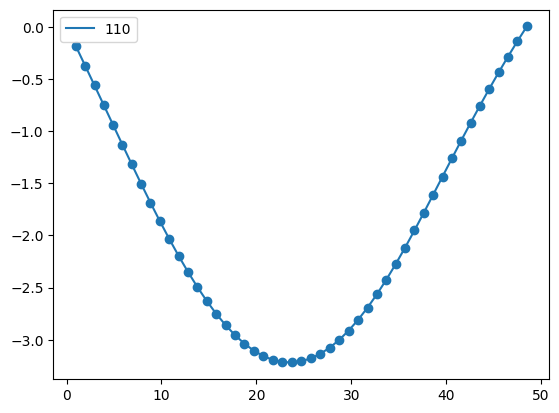

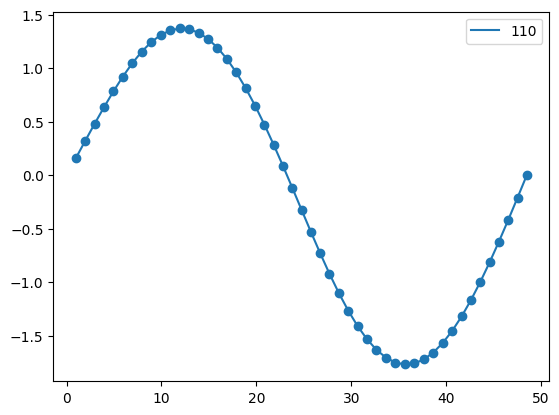

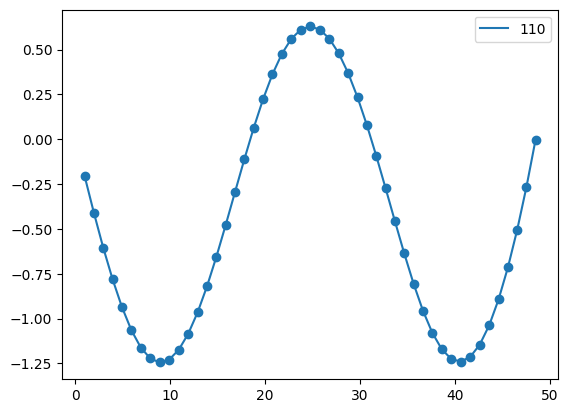

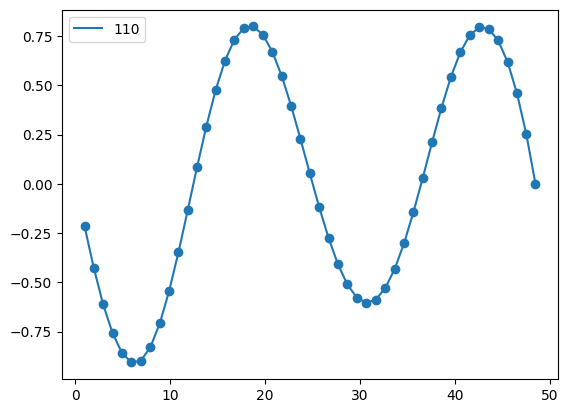

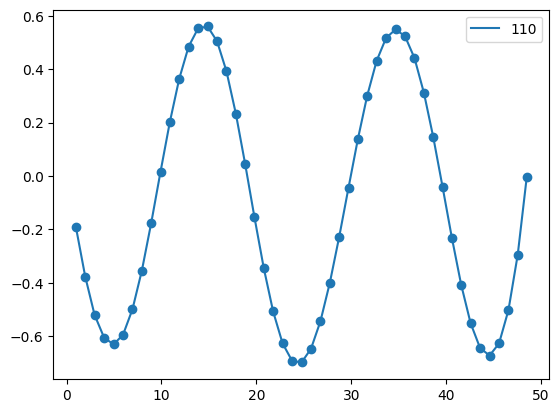

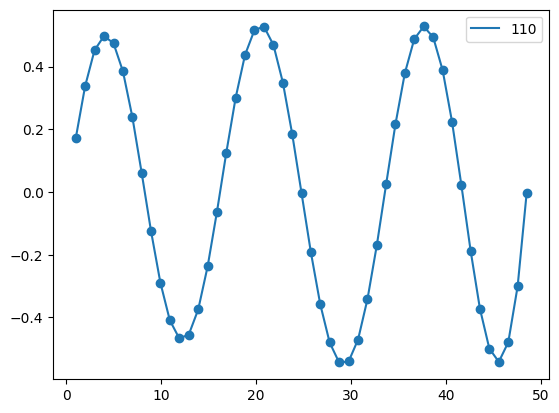

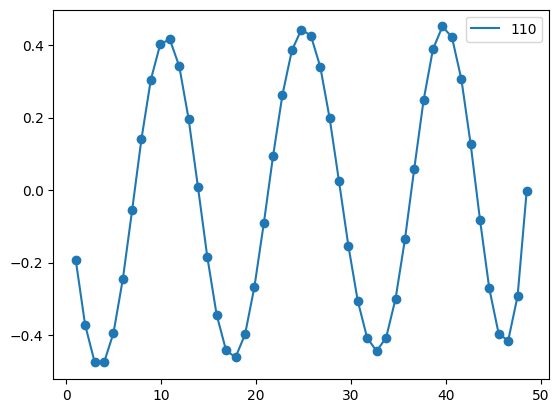

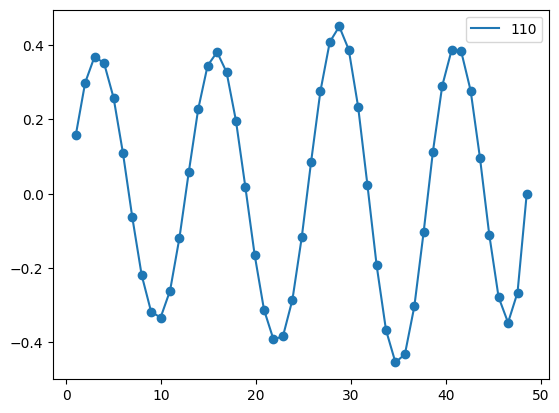

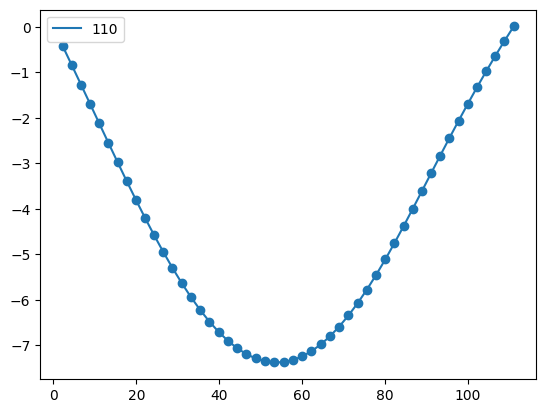

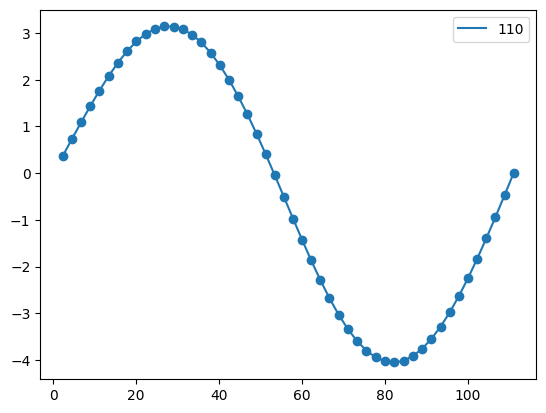

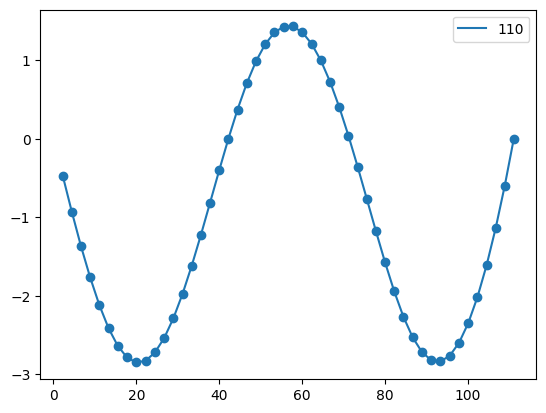

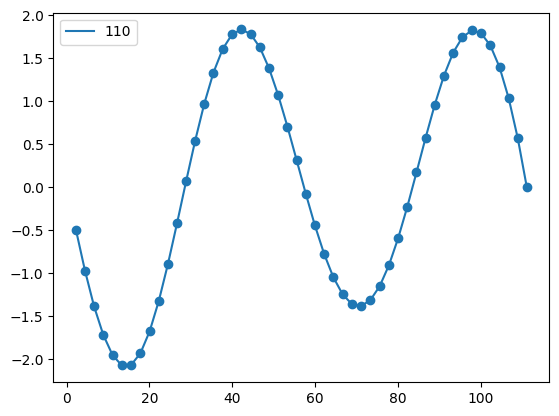

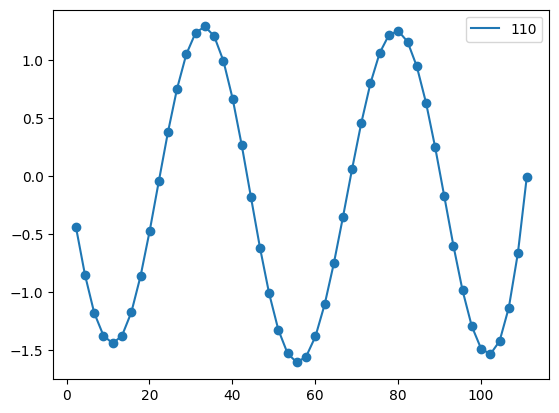

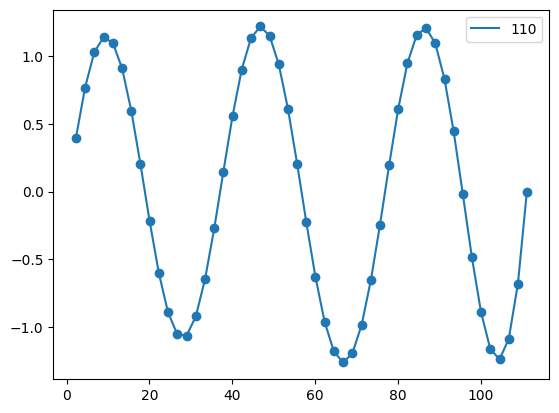

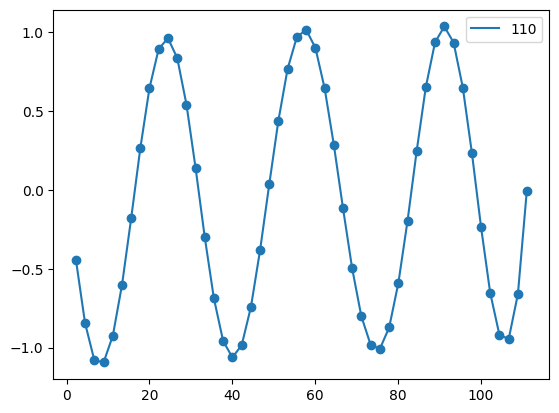

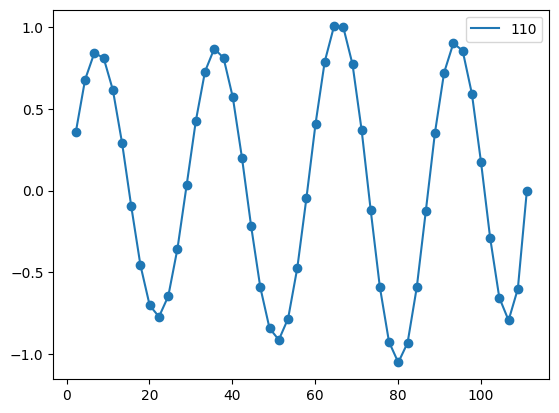

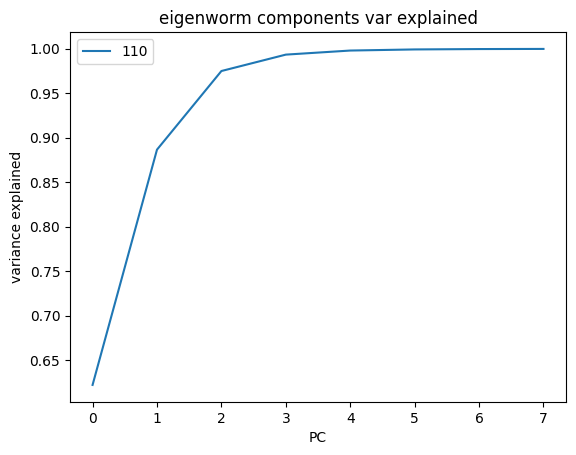

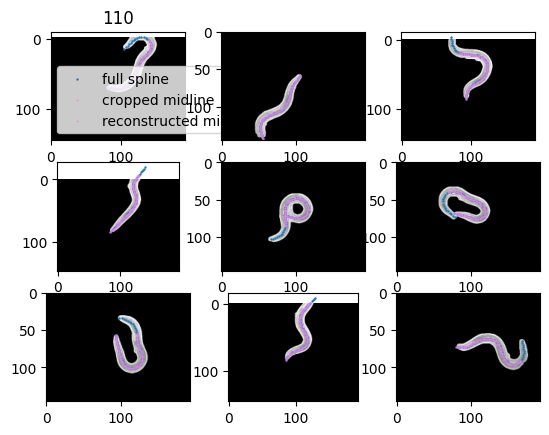

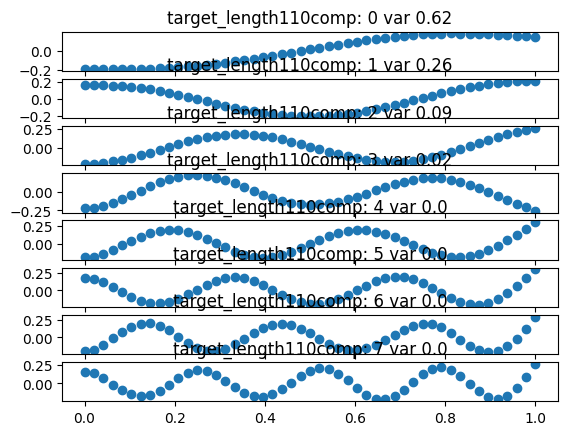

In [12]:
# midline_save_dir = "/Users/friederikebuck/Desktop/MBL/project/figs/eigenworm_length_cuttoff_masked/"
'''
get eigenworms for different midline lengths 
'''


# midlines = get_midlines_from_worm_tracer_csv(raw_nir_midlines_dir, is_midline_flipped = is_midline_flipped)

ds = 0.02 
n_components = 8
num_resample_pts = 50
'''
plot components as midlines ; overlain for different lengths 
'''
comp_fig_axs = [plt.subplots() for i in range(n_components)]
comp_fig_axs1 = [plt.subplots() for i in range(n_components)]

explained_var_fig, explained_var_ax = plt.subplots()

# for target_length in range(50,145, 10):
for target_length in [110]:
    if np.argwhere(midline_lengths>target_length).flatten().shape[0]<10: 
        continue



    full_splines, to_keep, cropped_midlines,centroids,  midline_angles, mean_angles,  components, var_explained =  get_cropped_midlines_eigenworms_and_body_angles(
                                                        midlines, 
                                                        target_length, 
                                                        frames_to_mask,
                                                        ds = ds, 
                                                        n_components = n_components, 
                                                        num_resample_pts = num_resample_pts
                                                        )
    reconstructed_body_angles, reconstructed_midlines, contributions = get_contributions_and_reconstruct_body_angles(
                                                                    components, 
                                                                    midline_angles,
                                                                    mean_angles, 
                                                                    centroids, 
                                                                    target_length
                                                                    )
    print("target_length, ", target_length,"to_keep.shape", np.argwhere(to_keep).shape )

    '''
    get midlines cropped to target length specified 
    get eigenworms (PCAs of worm postures = body angles along spline) + from cropped midline 
    save pics of worms with overlain
        - spline fitted to midline
        - midlines cropped to target length specified  
        - reconstructed mdilen from eigenworm 
    
    '''
    n_frames = midlines.shape[0]
    frames = np.random.randint(0, n_frames, 9).tolist()
    fig, ax = plt.subplots(3,3)
    ax[0,0].set_title(str(target_length))
    for i, frame in enumerate(frames):
        row, col = divmod(i, 3)
        img = cv2.imread(os.path.join(mask_img_dir, str(frame+1).zfill(5)+".png"))
        ax[row, col].imshow(img)
        ax[row, col].scatter(*full_splines[frame].T, s = 0.5, label = "full spline" )
        ax[row, col].scatter(*cropped_midlines[frame].T, s = 0.5, alpha = 0.5, c = "violet", label = "cropped midline")
        ax[row, col].scatter(*reconstructed_midlines[frame].T, s = 0.5, alpha = 0.5, c = "violet", label = "reconstructed midline")
    ax[0,0].legend()
    if save_figs:
        fig.savefig(os.path.join(fig_save_dir, "target_length"+str(target_length)+ "_ex_midlines.jpeg"))
        
    '''
    plot explained var from eigenworm contributions
    '''
    # fig, ax = plt.subplots()
    explained_var_ax.plot(np.arange(0, np.cumsum(var_explained).shape[0]), np.cumsum(var_explained), label = str(target_length))
    explained_var_ax.set_xlabel("PC")
    explained_var_ax.set_ylabel("variance explained")
    explained_var_ax.set_title("eigenworm components var explained")
    explained_var_ax.legend()
    # ax.set_title(f"eigenworm components var explained;\n target_length {target_length}")
    # if save_figs:
    #     fig.savefig(os.path.join(fig_save_dir, "target_length"+str(target_length)+ "eigenworm_ex_var.jpeg"))
    

            

    fig, axs = plt.subplots(n_components)
    for i in range(n_components):
        '''plot compoents as midlines'''
        axs[i].scatter(np.linspace(0,1,num = components.shape[1]),components[i,:])
        axs[i].set_title("target_length" + str(target_length) + "comp: "+ str(i)+ " var " + str(np.round(var_explained[i],2)))

        '''plot compenents as midlines (overlay different target_lengths)'''
        ax1 = comp_fig_axs[i][1]
        # ax1, fig1 = plt.subplots()
        midline_comp = convert_angles_to_coordinates(components[i,:], distances = [])#np.ones(components[i,:].shape[0])*target_length)
        ax1.scatter(*midline_comp.T)
        ax1.plot(*midline_comp.T, label = str(target_length))
        ax1.legend()
        # ax1.set_title( "target_length" + str(target_length) + "comp: "+ str(i)+ " var explained: " + str(np.round(var_explained[i],2)))
        ####
        ax1 = comp_fig_axs1[i][1]
        # ax1, fig1 = plt.subplots()
        resampled_comp = resample_midline(midline_comp, num_resample_pts =  50, final_length = target_length)
        # resampled_comp = resample_midline(midline_comp[i,:], num_resample_pts =  50*(target_length/120))#, final_length = target_length)
        ax1.scatter(*resampled_comp.T)
        ax1.plot(*resampled_comp.T, label = str(target_length) )
        ax1.legend()
        # fig1.savefig(os.path.join(midline_save_dir, "target_length"+str(target_length)+ "comp"+ str(i)+".jpeg"))
    if save_figs:
        fig.savefig(os.path.join(fig_save_dir, "target_length"+str(target_length)+ "all_comps.jpeg"))
        explained_var_fig.savefig(os.path.join(fig_save_dir, "expalined_var_all_lengths.jpeg"))
# if save_figs:
#     for i, (fig, ax) in enumerate(comp_fig_axs):
#         ax.legend()
#         fig.savefig(os.path.join(fig_save_dir, "comp_with_dist"+ str(i)+".jpeg"))

#     for i, (fig, ax) in enumerate(comp_fig_axs1):
        
#         fig.savefig(os.path.join(fig_save_dir, "comp_resampled_"+ str(i)+".jpeg"))



target_length,  110 to_keep.shape (19174, 1)


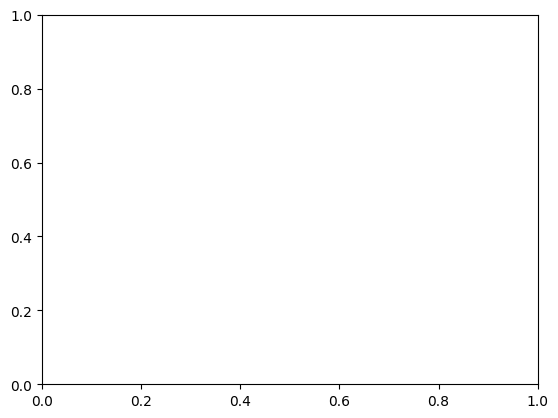

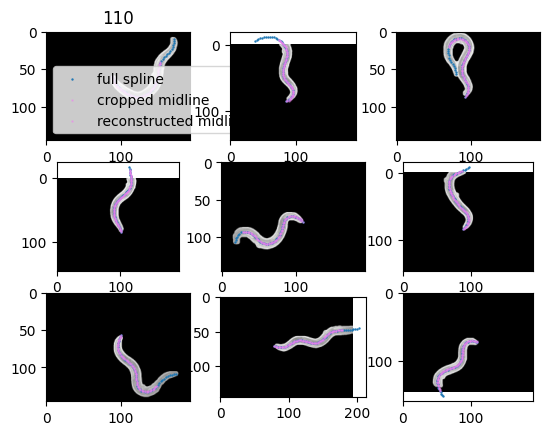

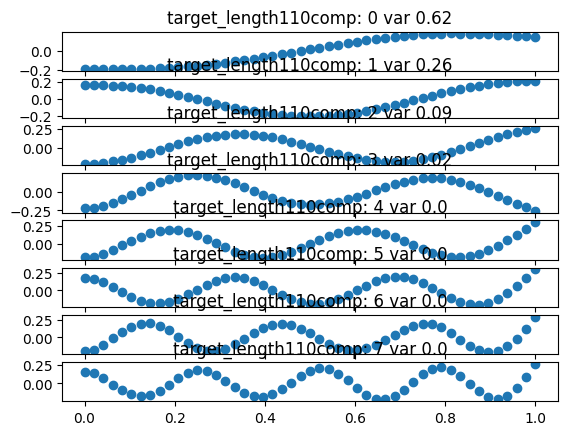

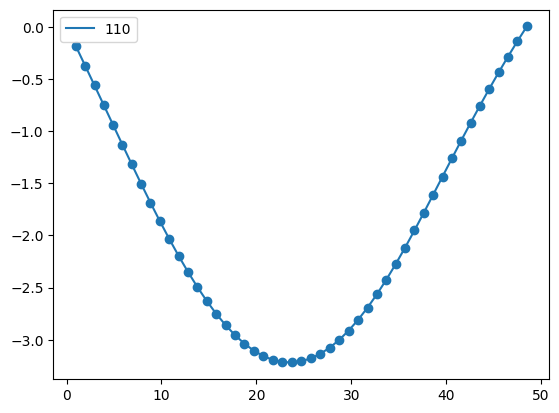

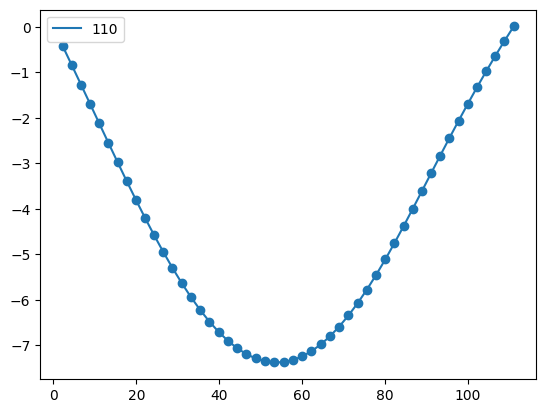

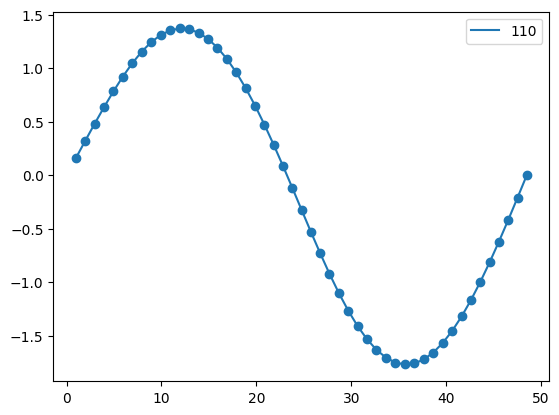

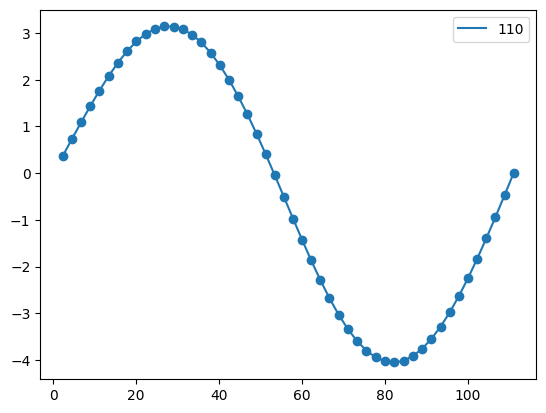

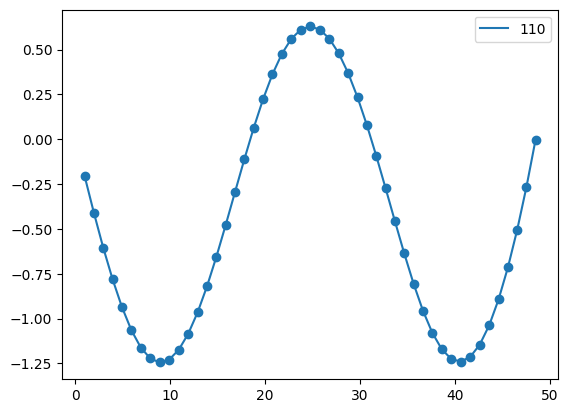

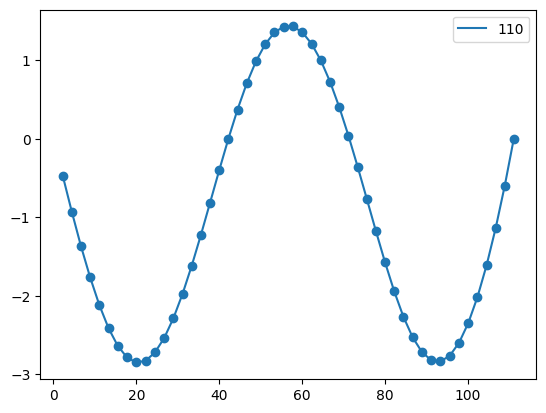

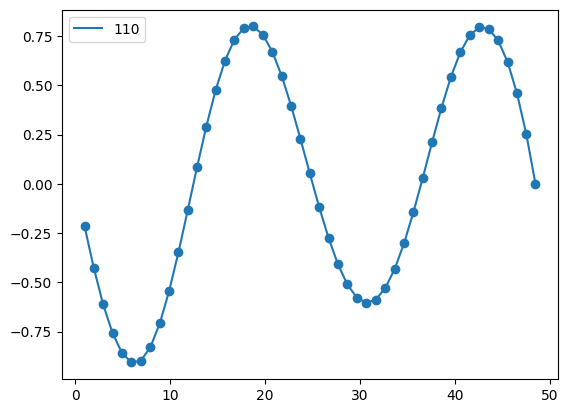

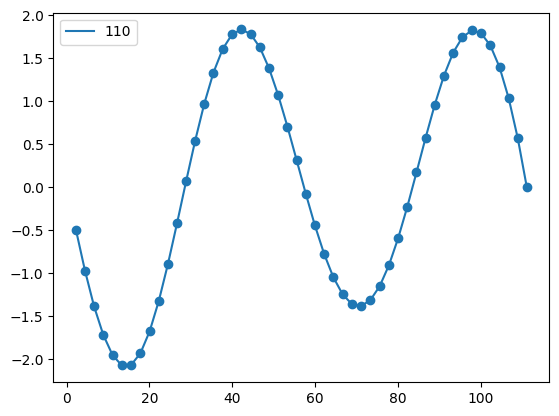

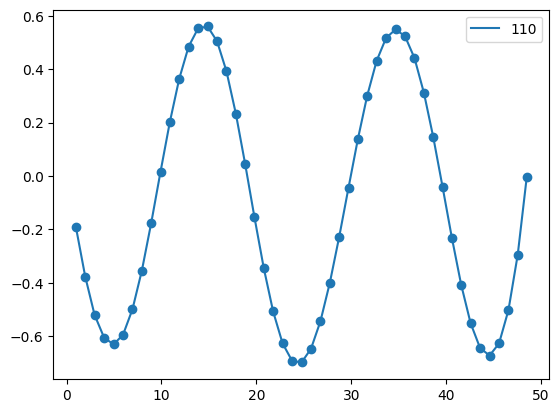

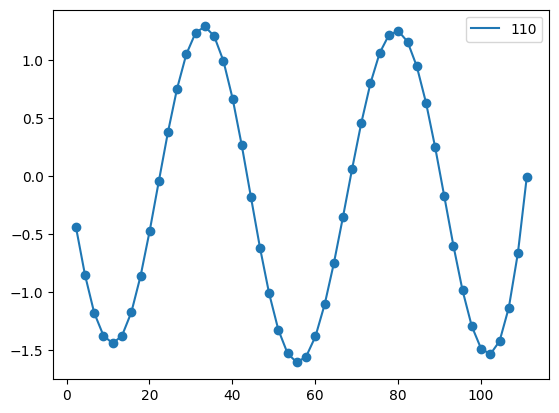

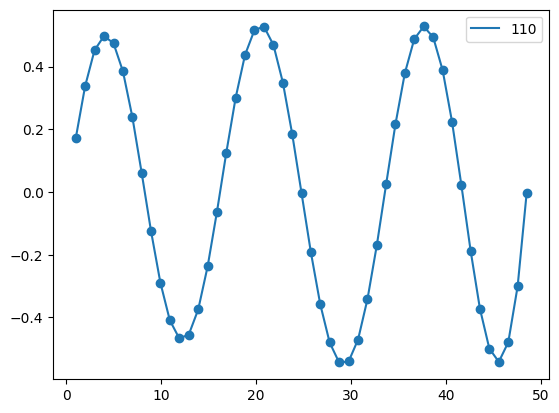

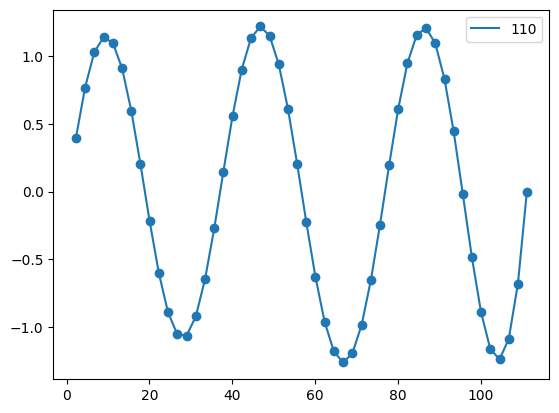

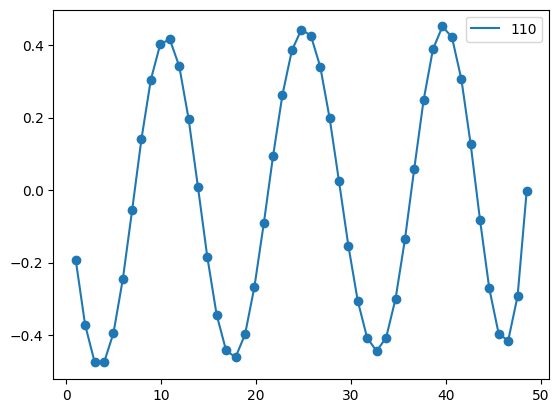

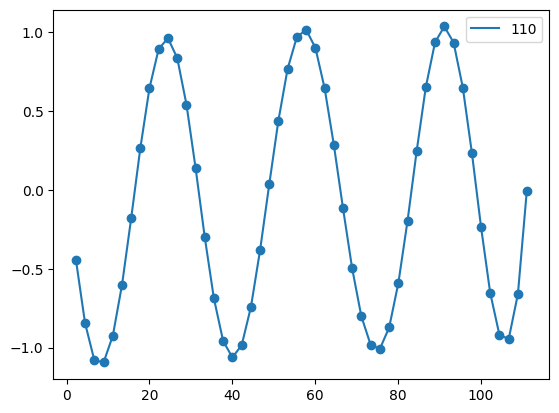

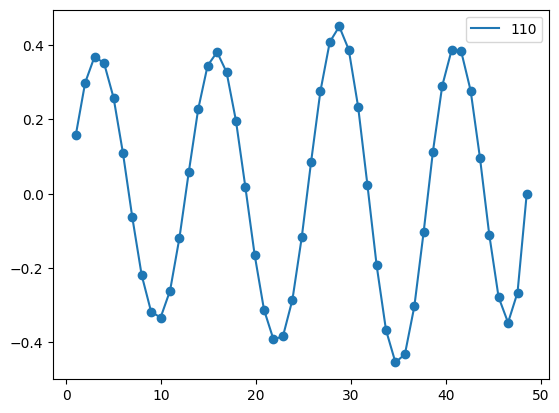

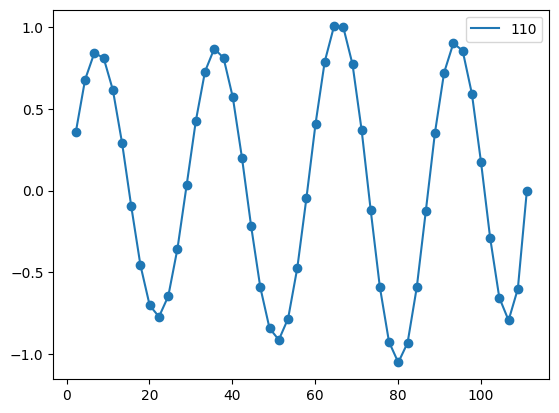

In [13]:
# midline_save_dir = "/Users/friederikebuck/Desktop/MBL/project/figs/eigenworm_length_cuttoff_masked/"
'''
get eigenworms for different midline lengths 
'''


# midlines = get_midlines_from_worm_tracer_csv(raw_nir_midlines_dir, is_midline_flipped = is_midline_flipped)

ds = 0.02 
n_components = 8
num_resample_pts = 50
'''
plot components as midlines ; overlain for different lengths 
'''

explained_var_fig, explained_var_ax = plt.subplots()

# target_lengths = range(50,145, 10)
target_lengths = [110] 
for target_length in target_lengths:
    if np.argwhere(midline_lengths>target_length).flatten().shape[0]<10: 
        continue



    full_splines, to_keep, cropped_midlines,centroids,  midline_angles, mean_angles,  components, var_explained =  get_cropped_midlines_eigenworms_and_body_angles(
                                                        midlines, 
                                                        target_length, 
                                                        frames_to_mask,
                                                        ds = ds, 
                                                        n_components = n_components, 
                                                        num_resample_pts = num_resample_pts
                                                        )
    reconstructed_body_angles, reconstructed_midlines, contributions = get_contributions_and_reconstruct_body_angles(
                                                                    components, 
                                                                    midline_angles,
                                                                    mean_angles, 
                                                                    centroids, 
                                                                    target_length
                                                                    )
    print("target_length, ", target_length,"to_keep.shape", np.argwhere(to_keep).shape )

    '''
    get midlines cropped to target length specified 
    get eigenworms (PCAs of worm postures = body angles along spline) + from cropped midline 
    save pics of worms with overlain
        - spline fitted to midline
        - midlines cropped to target length specified  
        - reconstructed mdilen from eigenworm 
    
    '''
    n_frames = midlines.shape[0]
    frames = np.random.randint(0, n_frames, 9).tolist()
    fig, ax = plt.subplots(3,3)
    ax[0,0].set_title(str(target_length))
    for i, frame in enumerate(frames):
        row, col = divmod(i, 3)
        img = cv2.imread(os.path.join(mask_img_dir, str(frame+1).zfill(5)+".png"))
        ax[row, col].imshow(img)
        ax[row, col].scatter(*full_splines[frame].T, s = 0.5, label = "full spline" )
        ax[row, col].scatter(*cropped_midlines[frame].T, s = 0.5, alpha = 0.5, c = "violet", label = "cropped midline")
        ax[row, col].scatter(*reconstructed_midlines[frame].T, s = 0.5, alpha = 0.5, c = "violet", label = "reconstructed midline")
    ax[0,0].legend()
    if save_figs:
        fig.savefig(os.path.join(fig_save_dir, "target_length"+str(target_length)+ "_ex_midlines.jpeg"))

            
    fig, axs = plt.subplots(n_components)
    for i in range(n_components):
        '''plot compoents as midlines'''
        axs[i].scatter(np.linspace(0,1,num = components.shape[1]),components[i,:])
        axs[i].set_title("target_length" + str(target_length) + "comp: "+ str(i)+ " var " + str(np.round(var_explained[i],2)))

        '''plot compenents as midlines (overlay different target_lengths)'''
        fig1, ax1 = plt.subplots()
        midline_comp = convert_angles_to_coordinates(components[i,:], distances = [])#np.ones(components[i,:].shape[0])*target_length)
        ax1.scatter(*midline_comp.T)
        ax1.plot(*midline_comp.T, label = str(target_length))
        ax1.legend()
        # ax1.set_title( "target_length" + str(target_length) + "comp: "+ str(i)+ " var explained: " + str(np.round(var_explained[i],2)))
        ####
        fig2, ax2 = plt.subplots()
        resampled_comp = resample_midline(midline_comp, num_resample_pts =  50, final_length = target_length)
        # resampled_comp = resample_midline(midline_comp[i,:], num_resample_pts =  50*(target_length/120))#, final_length = target_length)
        ax2.scatter(*resampled_comp.T)
        ax2.plot(*resampled_comp.T, label = str(target_length) )
        ax2.legend()
        # fig1.savefig(os.path.join(midline_save_dir, "target_length"+str(target_length)+ "comp"+ str(i)+".jpeg"))
    if save_figs:
        fig.savefig(os.path.join(fig_save_dir, "target_length"+str(target_length)+ ".jpeg"))


TypeError: get_text_nir_resampled() got an unexpected keyword argument 'a_to_p'

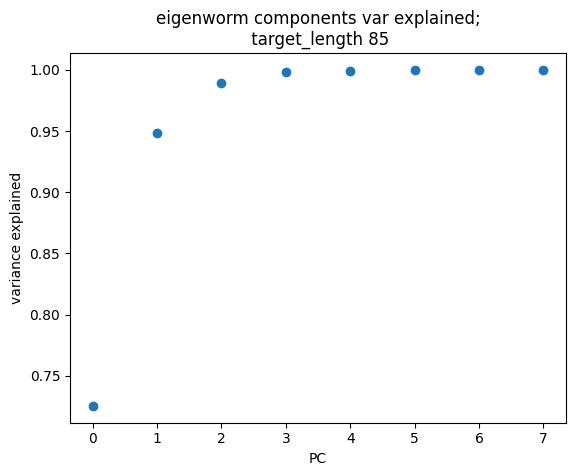

In [14]:
'''
save frames, midlines, splines, contributions for all nir frames 
'''
# mask_annotations = [
# list(range(1013, 1124)),  #  loopy and really doesnt caputure loopiness well.. can abstract awway as turn if want to.. 
# list(range(7646, 7737)),  #  loopy and really doesnt caputure loopiness well.. can abstract awway as turn if want to.. 
# list(range(12437, 12617)),  #  loopy and really doesnt caputure loopiness well.. can abstract awway as turn if want to.. 
# list(range(16679, 16858)), #issue with stage -->  doesnt align to head super well
# ]
# mask_annotations = np.concatenate([np.array(f) for f in mask_annotations])
mask_annotations = copy.deepcopy(frames_to_mask)
# midlines = get_midlines_from_worm_tracer_csv(raw_nir_midlines_dir,  is_midline_flipped = is_midline_flipped)
save_mask_img = True
ds = 0.02 
n_components = 8
num_resample_pts = 50
# target_lengths = np.arange(100, 135, 10)
target_lengths = [85]

for target_length in target_lengths:#, 100, 115]:
    frames_to_mask = copy.deepcopy(mask_annotations)
    full_splines, to_keep, cropped_midlines,centroids,  midline_angles, mean_angles,  components, var_explained =  get_cropped_midlines_eigenworms_and_body_angles(
                                                        midlines, 
                                                        target_length, 
                                                        frames_to_mask,
                                                        ds = ds, 
                                                        n_components = n_components, 
                                                        num_resample_pts = num_resample_pts
                                                        )


    fig, ax = plt.subplots()
    ax.scatter(np.arange(0, np.cumsum(var_explained).shape[0]), np.cumsum(var_explained))
    ax.set_xlabel("PC")
    ax.set_ylabel("variance explained")
    ax.set_title(f"eigenworm components var explained;\n target_length {target_length}")
    reconstructed_body_angles, reconstructed_midlines, contributions_nir = get_contributions_and_reconstruct_body_angles(
                                                                        components, 
                                                                        midline_angles,
                                                                        mean_angles, 
                                                                        centroids, 
                                                                        target_length
                                                                        )
    
    '''
    get midlines cropped to target length specified 
    get eigenworms (PCAs of worm postures = body angles along spline) + from cropped midline 
    save pics of worms with overlain
        - spline fitted to midline
        - midlines cropped to target length specified  
        - reconstructed mdilen from eigenworm 
    
    plot explained var from eigenworm contributions
    '''


    masked = np.logical_not(to_keep)
    get_text_fnc = partial(
                            get_text_nir_midlines, 
                            nir_to_confocal = nir_to_confocal, 
                            state_strs = beh_strs, 
                            masked = masked, 
                            
                                
                                )
 
    # output_dir = f"/Users/friederikebuck/Desktop/MBL/project/figs/{exp_date}/eigenworm_masked_091724/"
    masked_annotated_img_output_dir = make_new_folder(os.path.join(img_save_dir, f"annotated_masked_imgs_nir"))
    make_new_folder(masked_annotated_img_output_dir)
    n_frames = z_nir.shape[0]

    frames = np.arange(0, n_frames)
    save_masked_imgs_and_annotations(
        mask_img_dir, 
        frames, 
        masked_annotated_img_output_dir, 
        get_text_fnc, 
        reconstructed_midlines, 
        z_nir,
        save_mask_img = False,
        masked_img_output_dir = None, 
        imgs = None
    )
    if save_csvs:

        csv_name = os.path.join(csv_save_dir, f"target_length_{target_length}_reconstructed_body_angles_nir.csv")
        np.savetxt(csv_name,  reconstructed_body_angles, delimiter=",", fmt='%f')
        
        
        csv_name = os.path.join(csv_save_dir, f"target_length_{target_length}_contributions_nir.csv")
        np.savetxt(csv_name,  contributions_nir, delimiter=",", fmt='%f')

        csv_name = os.path.join(csv_save_dir, f"target_length_{target_length}_eigenworm_components.csv")
        np.savetxt(csv_name,  components, delimiter=",", fmt='%f')


        csv_name = os.path.join(csv_save_dir,"beh_confocal.csv")
        np.savetxt(csv_name,  z_confocal, delimiter=",", fmt='%f')
        
        csv_name = os.path.join(csv_save_dir,"beh_nir.csv")
        np.savetxt(csv_name,  z_nir, delimiter=",", fmt='%f')
        

        masked_nir = copy.deepcopy(masked)
        csv_name = os.path.join(csv_save_dir,f"target_length_{target_length}_masked_nir.csv")
        np.savetxt(csv_name,  masked_nir, delimiter=",", fmt='%f')
        
        csv_name = os.path.join(csv_save_dir,f"target_length_{target_length}_all_midlines_coords_nir.csv")
        save_as_csv(reconstructed_midlines, csv_name)
        
    
    '''
    resample features, midlines, etc into new time frame via interpolation
    (either to nir-> confocal time frame 
    of 
    nir-> new timeframe (ie for moseq because different numbers ie nir frames contribute to a single confocal frame 
    ie vals, counts = np.unique(nir_to_confocal, return_counts)
    np.all(np.diff(counts[1:])==0) = False
    )
    '''

        
    time_bins=10

    masked_annotated_img_output_dir = make_new_folder(os.path.join(img_save_dir, f"annotated_masked_imgs_resampled_timebin_{time_bins}_target_length{target_length}"))
    masked_img_output_dir = make_new_folder(os.path.join(img_save_dir, f"masked_imgs_resampled_timebin_{time_bins}_target_length{target_length}"))

    if not save_mask_img: 
        masked_img_output_dir = None
        
    # mask_img_dir = make_new_folder(os.path.join(img_save_dir, f"masked_imgs_resampled_timebin_{time_bins}"))
    # make_new_folder(mask_img_dir, "")

    midlines_resampled, beh_resampled, mask_resampled = evenly_sample_nir_and_save(nir_to_confocal, 
                                reconstructed_midlines,
                                z_nir, 
                                masked,
                                velocity_nir, 
                                a_to_ps,
                                
                                mask_img_dir,
                                masked_annotated_img_output_dir,

                                # org_midlines = midlines, 
                                time_bins=time_bins, 
                                
                                save_mask_img = save_mask_img,
                                masked_img_output_dir = masked_img_output_dir, 
                )
    if save_csvs:
        midlines_resampled1 =  evenly_sample_feature(reconstructed_midlines, 
                                nir_to_confocal,
                                time_bins=10, )
        beh_resampled1 =  evenly_sample_feature(z_nir, 
                                nir_to_confocal,
                                time_bins=10, ).flatten().astype('int')
        mask_resampled1 = evenly_sample_feature(masked, 
                                nir_to_confocal,
                                time_bins=10, ).flatten().astype('int')
        
        
        csv_name = os.path.join(csv_save_dir, f"midlines_resampled_target_length_{target_length}_timebin_{time_bins}.csv")
        save_as_csv(midlines_resampled1, csv_name)

        csv_name = os.path.join(csv_save_dir, f"behavior_resampled_timebin_{time_bins}.csv")
        np.savetxt(csv_name,  beh_resampled1, delimiter=",", fmt='%f')


        csv_name = os.path.join(csv_save_dir,f"mask_resampled_target_length_{target_length}_timebin_{time_bins}.csv")
        np.savetxt(csv_name,  mask_resampled1, delimiter=",", fmt='%f')

    
        '''
        get contributions 
        '''
        csv_name = os.path.join(csv_save_dir, f"target_length_{target_length}_contributions_nir.csv")
        eigenworm_contributions_nir = np.loadtxt(csv_name, delimiter=",")
        eigenworm_contributions_resampled = evenly_sample_feature(eigenworm_contributions_nir, 
                                nir_to_confocal,
                                time_bins=time_bins)
        csv_name = os.path.join(csv_save_dir, f"target_length{target_length}contributions_resampled_{time_bins}.csv")
        # save_as_csv(  eigenworm_contributions_resampled, csv_name)
        np.savetxt(csv_name, eigenworm_contributions_resampled, delimiter=",", fmt='%f')




    '''
    resampling with 1 time bin is equiv to getting confocal imgs 
    '''
    time_bins=1
    masked_annotated_img_output_dir = make_new_folder(os.path.join(img_save_dir, f"annotated_masked_imgs_resampled_timebin_{time_bins}_target_length{target_length}"))
    masked_img_output_dir = make_new_folder(os.path.join(img_save_dir, f"masked_imgs_resampled_timebin_{time_bins}_target_length{target_length}"))

    if not save_mask_img: 
        masked_img_output_dir = None
        

    # mask_img_dir = make_new_folder(os.path.join(img_save_dir, f"masked_imgs_resampled_timebin_{time_bins}"))
    # make_new_folder(mask_img_dir, "")


    midlines_resampled, beh_resampled, mask_resampled = evenly_sample_nir_and_save(nir_to_confocal, 
                                reconstructed_midlines,
                                z_nir, 
                                masked,
                                velocity_nir,
                                mask_img_dir,
                                masked_annotated_img_output_dir, 
                                # org_midlines = midlines, 

                                time_bins=time_bins, 
                                
                                save_mask_img = save_mask_img,
                                masked_img_output_dir = masked_img_output_dir, 
                )

    midlines_resampled1 = evenly_sample_feature(reconstructed_midlines, 
                            nir_to_confocal,
                            time_bins=time_bins)
    beh_resampled1 =  evenly_sample_feature(z_nir, 
                            nir_to_confocal,
                            time_bins=time_bins, ).flatten().astype('int')
    mask_resampled1 = evenly_sample_feature(masked, 
                            nir_to_confocal,
                            time_bins=time_bins, ).flatten().astype('int')
    if save_csvs:
        # print(np.all(midlines_resampled.astype('uint8') ==midlines_resampled1))#figureout why midlines_resampled is type uint8
        # print(np.all(beh_resampled == beh_resampled1)) # True
        # print(np.all(z_confocal == beh_resampled1)) #True
        # print(np.all(mask_resampled ==mask_resampled1)) #True

        csv_name = os.path.join(csv_save_dir, f"midlines_resampled_target_length_{target_length}_timebin_{time_bins}.csv")
        save_as_csv(midlines_resampled, csv_name)

        # csv_name = os.path.join(csv_save_dir, f"midlines_resampled_target_length_{target_length}_timebin_{time_bins}.csv")
        # save_as_csv(midlines_resampled1, csv_name)

        # csv_name = os.path.join(csv_save_dir, f"behavior_resampled_timebin_{time_bins}.csv")
        # np.savetxt(csv_name,  beh_resampled1, delimiter=",", fmt='%f')


        # csv_name = os.path.join(csv_save_dir,f"mask_resampled_target_length_{target_length}_timebin_{time_bins}.csv")
        # np.savetxt(csv_name,  mask_resampled1, delimiter=",", fmt='%f')
        # eigenworm_contributions_resampled = evenly_sample_feature(eigenworm_contributions_nir, 
        #                         nir_to_confocal,
        #                         time_bins=time_bins)
        # csv_name = os.path.join(csv_save_dir, f"target_length{target_length}contributions_resampled_{time_bins}.csv")
        # # save_as_csv( eigenworm_contributions_resampled, csv_name)
        # np.savetxt(csv_name, eigenworm_contributions_resampled, delimiter=",", fmt='%f')


